***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [12]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']
df_html.drop(rem,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)

Shape of our dataset: (43491, 1434)


In [13]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)


df_js.drop(['js_function_Object.defineProperty(',
'js_function_Object.keys(',
'js_function_.substr'],axis=1,inplace=True)
print("Shape of our dataset:",df_js.shape)

Shape of our dataset: (43294, 398)


In [14]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)

### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)
df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

num_stats_js=num_stats(df_js,num_var_js)
cat_stats_js=cat_stats(df_js,cat_var_js)


num_stats_html=num_stats(df_html,num_var_html)
cat_stats_html=cat_stats(df_html,cat_var_html)

add_feat=['js_function_escape(',
 'js_function_parseInt(',
 'js_function_unescape(',
 'small_count',
 'style_count',
 'input_count']

fin_col=num_stats_js.index.values[0:25].tolist()+ num_stats_html.index.values[0:25].tolist()
fin_col.extend(add_feat)

df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 57)

In [15]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [16]:
sorted(fin_col)

['Target',
 'a_count',
 'a_href_https',
 'div_count',
 'dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_window.addEventListener(',
 'iframe_count',
 'iframe_src_https',
 'iframe_src_relative',
 'img_src_.jpg',
 'img_src_absolute',
 'img_src_https',
 'input_count',
 'js_function_.apply(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.getTime(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_JSON.parse(',
 'js_function_Math.floor(',
 'js_function_Math.random(',
 'js_function_Math.round(',
 'js_function_decodeURIComponent(',
 'js_function_encodeURIComponent(',
 'js_function_escape(',
 'js_function_parseInt(',
 'js_function_unescape(',
 'link_co

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [17]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [18]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.872416863696
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27666   172    27838
True        3983   746     4729
__all__    31649   918    32567

Accuracy of the model for test data is: 0.865266519283
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6881    59     6940
True        1038   164     1202
__all__     7919   223     8142



Logistic Regression
Accuracy of the model for training data is: 0.87447416096
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24673  3165    27838
True         923  3806     4729
__all__    25596  6971    32567

Accuracy of the model for test data is: 0.878039793662
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6155   785     6940
True         208   994     1202
__all__     6363  1779     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.91036939233
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25030  2808    27838
True         111  4618     4729
__all__    25141  7426    32567

Accuracy of the model for test data is: 0.897322525178
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6215   725     6940
True         111  1091     1202
__all__     6326  1816     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.87539533884
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24542  3296    27838
True         762  3967     4729
__all__    25304  7263    32567

Accuracy of the model for test data is: 0.875460574797
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6115   825     6940
True         189  1013     1202
__all__     6304  1838     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.89602972334
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24982  2856    27838
True         530  4199     4729
__all__    25512  7055    32567

Accuracy of the model for test data is: 0.892778187178
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6209   731     6940
True         142  1060     1202
__all__     6351  1791     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.912488101452
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25035  2803    27838
True          47  4682     4729
__all__    25082  7485    32567

Accuracy of the model for test data is: 0.898550724638
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6219   721     6940
True         105  1097     1202
__all__     6324  1818     8142



Bagging Classifier
Accuracy of the model for training data is: 0.910615039764
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25030  2808    27838
True         103  4626     4729
__all__    25133  7434    32567

Accuracy of the model for test data is: 0.895603045935
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6198   742     6940
True         108  1094     1202
__all__     6306  1836     8142



Neural Network-1
The accuracy of the model on training data is: 0.896306076713


Predicted  False  True  __all__
Actual                         
False      24601  3237    27838
True         140  4589     4729
__all__    24741  7826    32567

The accuracy of the model on test data is: 0.884426430852


Predicted  False  True  __all__
Actual                         
False       6095   845     6940
True          96  1106     1202
__all__     6191  1951     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [19]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [20]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.872417,746.0,27666.0,172.0,3983.0,0.006179,0.842250
LogisticRegression,0.874474,3806.0,24673.0,3165.0,923.0,0.113694,0.195179
RandomForestClassifier,0.910369,4618.0,25030.0,2808.0,111.0,0.100869,0.023472
AdaBoostClassifier,0.875395,3967.0,24542.0,3296.0,762.0,0.118399,0.161133
GradientBoostingClassifier,0.896030,4199.0,24982.0,2856.0,530.0,0.102594,0.112074
ExtraTreeClassifier,0.912488,4682.0,25035.0,2803.0,47.0,0.100690,0.009939
BaggingClassifier,0.910615,4626.0,25030.0,2808.0,103.0,0.100869,0.021781
Neural Network-1,0.896306,4589.0,24601.0,3237.0,140.0,0.116280,0.029605


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.865267,164.0,6881.0,59.0,1038.0,0.008501,0.863561,0.563969,0.278063
LogisticRegression,0.878040,994.0,6155.0,785.0,208.0,0.113112,0.173045,0.856921,0.612795
RandomForestClassifier,0.897323,1091.0,6215.0,725.0,111.0,0.104467,0.092346,0.901594,0.684425
AdaBoostClassifier,0.875461,1013.0,6115.0,825.0,189.0,0.118876,0.157238,0.861943,0.614216
GradientBoostingClassifier,0.892778,1060.0,6209.0,731.0,142.0,0.105331,0.118136,0.888266,0.665001
ExtraTreeClassifier,0.898551,1097.0,6219.0,721.0,105.0,0.103890,0.087354,0.904378,0.688900
BaggingClassifier,0.895603,1094.0,6198.0,742.0,108.0,0.106916,0.089850,0.901617,0.681805
Neural Network-1,0.884426,1106.0,6095.0,845.0,96.0,0.121758,0.079867,0.901617,0.663483


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [21]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [22]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [23]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.93045477405
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24299   3539    27838
True         333  27505    27838
__all__    24632  31044    55676

Accuracy of the model for test data is: 0.873372635716
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5988   952     6940
True          79  1123     1202
__all__     6067  2075     8142



Logistic Regression
Accuracy of the model for training data is: 0.886791436166
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22579   5259    27838
True        1044  26794    27838
__all__    23623  32053    55676

Accuracy of the model for test data is: 0.833333333333
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5637  1303     6940
True          54  1148     1202
__all__     5691  2451     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.947338170846
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24974   2864    27838
True          68  27770    27838
__all__    25042  30634    55676

Accuracy of the model for test data is: 0.895848685827
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True          94  1108     1202
__all__     6280  1862     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.902974351606
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23613   4225    27838
True        1177  26661    27838
__all__    24790  30886    55676

Accuracy of the model for test data is: 0.862441660526
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5894  1046     6940
True          74  1128     1202
__all__     5968  2174     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.924563546232
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24250   3588    27838
True         612  27226    27838
__all__    24862  30814    55676

Accuracy of the model for test data is: 0.88086465242
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6050   890     6940
True          80  1122     1202
__all__     6130  2012     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.948200301746
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24983   2855    27838
True          29  27809    27838
__all__    25012  30664    55676

Accuracy of the model for test data is: 0.897199705232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6197   743     6940
True          94  1108     1202
__all__     6291  1851     8142



Bagging Classifier
Accuracy of the model for training data is: 0.947374092966
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24974   2864    27838
True          66  27772    27838
__all__    25040  30636    55676

Accuracy of the model for test data is: 0.894006386637
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6164   776     6940
True          87  1115     1202
__all__     6251  1891     8142



Neural Network-1
The accuracy of the model on training data is: 0.935861053237


Predicted  False   True  __all__
Actual                          
False      24322   3516    27838
True          55  27783    27838
__all__    24377  31299    55676

The accuracy of the model on test data is: 0.877794153771


Predicted  False  True  __all__
Actual                         
False       6012   928     6940
True          67  1135     1202
__all__     6079  2063     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.930455,27505.0,24299.0,3539.0,333.0,0.127128,0.011962
LogisticRegression,0.886791,26794.0,22579.0,5259.0,1044.0,0.188914,0.037503
RandomForestClassifier,0.947338,27770.0,24974.0,2864.0,68.0,0.102881,0.002443
AdaBoostClassifier,0.902974,26661.0,23613.0,4225.0,1177.0,0.151771,0.042280
GradientBoostingClassifier,0.924564,27226.0,24250.0,3588.0,612.0,0.128889,0.021984
ExtraTreeClassifier,0.948200,27809.0,24983.0,2855.0,29.0,0.102558,0.001042
BaggingClassifier,0.947374,27772.0,24974.0,2864.0,66.0,0.102881,0.002371
Neural Network-1,0.935861,27783.0,24322.0,3516.0,55.0,0.126302,0.001976


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.873373,1123.0,5988.0,952.0,79.0,0.137176,0.065724,0.898550,0.648857
LogisticRegression,0.833333,1148.0,5637.0,1303.0,54.0,0.187752,0.044925,0.883661,0.593395
RandomForestClassifier,0.895849,1108.0,6186.0,754.0,94.0,0.108646,0.078203,0.906576,0.686805
AdaBoostClassifier,0.862442,1128.0,5894.0,1046.0,74.0,0.150720,0.061564,0.893858,0.631622
GradientBoostingClassifier,0.880865,1122.0,6050.0,890.0,80.0,0.128242,0.066556,0.902601,0.662205
ExtraTreeClassifier,0.897200,1108.0,6197.0,743.0,94.0,0.107061,0.078203,0.907368,0.689582
BaggingClassifier,0.894006,1115.0,6164.0,776.0,87.0,0.111816,0.072379,0.907903,0.685327
Neural Network-1,0.877794,1135.0,6012.0,928.0,67.0,0.133718,0.055740,0.907903,0.661061


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [28]:
fin_col

['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'dom_function_document.getElementById(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_

In [30]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]

In [31]:
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

Shape after undersampling (9458, 56)


In [32]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [33]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.561535208289
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4586   143     4729
True        4004   725     4729
__all__     8590   868     9458

Accuracy of the model for test data is: 0.831245394252
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6618   322     6940
True        1052   150     1202
__all__     7670   472     8142



Logistic Regression
Accuracy of the model for training data is: 0.879572848382
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3797   932     4729
True         207  4522     4729
__all__     4004  5454     9458

Accuracy of the model for test data is: 0.828788995333
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5604  1336     6940
True          58  1144     1202
__all__     5662  2480     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.944174244026
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4242   487     4729
True          41  4688     4729
__all__     4283  5175     9458

Accuracy of the model for test data is: 0.887128469663
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6099   841     6940
True          78  1124     1202
__all__     6177  1965     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.891520406005
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3964   765     4729
True         261  4468     4729
__all__     4225  5233     9458

Accuracy of the model for test data is: 0.856669123066
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5845  1095     6940
True          72  1130     1202
__all__     5917  2225     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.909071685346
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4068   661     4729
True         199  4530     4729
__all__     4267  5191     9458

Accuracy of the model for test data is: 0.869442397445
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5942   998     6940
True          65  1137     1202
__all__     6007  2135     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.947557623176
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4243   486     4729
True          10  4719     4729
__all__     4253  5205     9458

Accuracy of the model for test data is: 0.891058707934
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6127   813     6940
True          74  1128     1202
__all__     6201  1941     8142



Bagging Classifier
Accuracy of the model for training data is: 0.944808627617
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4237   492     4729
True          30  4699     4729
__all__     4267  5191     9458

Accuracy of the model for test data is: 0.88025055269
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6031   909     6940
True          66  1136     1202
__all__     6097  2045     8142



Neural Network-1
The accuracy of the model on training data is: 0.92768027062


Predicted  False  True  __all__
Actual                         
False       4080   649     4729
True          35  4694     4729
__all__     4115  5343     9458

The accuracy of the model on test data is: 0.854949643822


Predicted  False  True  __all__
Actual                         
False       5815  1125     6940
True          56  1146     1202
__all__     5871  2271     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [34]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [35]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.561535,725.0,4586.0,143.0,4004.0,0.030239,0.846691
LogisticRegression,0.879573,4522.0,3797.0,932.0,207.0,0.197082,0.043772
RandomForestClassifier,0.944174,4688.0,4242.0,487.0,41.0,0.102982,0.008670
AdaBoostClassifier,0.891520,4468.0,3964.0,765.0,261.0,0.161768,0.055191
GradientBoostingClassifier,0.909072,4530.0,4068.0,661.0,199.0,0.139776,0.042081
ExtraTreeClassifier,0.947558,4719.0,4243.0,486.0,10.0,0.102770,0.002115
BaggingClassifier,0.944809,4699.0,4237.0,492.0,30.0,0.104039,0.006344
Neural Network-1,0.927680,4694.0,4080.0,649.0,35.0,0.137238,0.007401


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.831245,150.0,6618.0,322.0,1052.0,0.046398,0.875208,0.539197,0.119000
LogisticRegression,0.828789,1144.0,5604.0,1336.0,58.0,0.192507,0.048253,0.879620,0.585194
RandomForestClassifier,0.887128,1124.0,6099.0,841.0,78.0,0.121182,0.064892,0.906963,0.674757
AdaBoostClassifier,0.856669,1130.0,5845.0,1095.0,72.0,0.157781,0.059900,0.891159,0.622730
GradientBoostingClassifier,0.869442,1137.0,5942.0,998.0,65.0,0.143804,0.054077,0.901060,0.646909
ExtraTreeClassifier,0.891059,1128.0,6127.0,813.0,74.0,0.117147,0.061564,0.910644,0.683730
BaggingClassifier,0.880251,1136.0,6031.0,909.0,66.0,0.130980,0.054908,0.907056,0.665903
Neural Network-1,0.854950,1146.0,5815.0,1125.0,56.0,0.162104,0.046589,0.907056,0.625911


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [36]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [37]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

Built 6216 features
EntitySet scattered to workers in 5.056 seconds
Elapsed: 00:48 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [38]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [39]:
def feat_transformation(data,feature):
    for i in range(0,len(feature)):
        for j in range(i,len(feature)):
            if feature[i]!=feature[j]:
                new_feat=str(feature[i])+"+"+str(feature[j])
                data[new_feat]=data[feature[i]]+data[feature[j]]
    
                new_feat=str(feature[i])+"*"+str(feature[j])
                data[new_feat]=data[feature[i]]*data[feature[j]]
             
                new_feat=str(feature[i])+"/"+str(feature[j])  
                data[new_feat]=data[feature[i]]/data[feature[j]]             

In [40]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [41]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [42]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [43]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [44]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [47]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 7)

In [48]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_out_of_domain / script_src_relative',
 'script_src_relative / script_count',
 'script_src_https / script_src_relative',
 'script_count + script_src_.js',
 'script_async_true / script_count',
 'link_href_absolute / link_count',
 'a_href_https / a_count']

In [49]:
fs=fs.reindex(df_sel.index.values)

In [50]:
train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [51]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [52]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.881567230632
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24394  3444    27838
True         413  4316     4729
__all__    24807  7760    32567

Accuracy of the model for test data is: 0.880741832474
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6083   857     6940
True         114  1088     1202
__all__     6197  1945     8142



Logistic Regression
Accuracy of the model for training data is: 0.868732152179
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24333  3505    27838
True         770  3959     4729
__all__    25103  7464    32567

Accuracy of the model for test data is: 0.870547776959
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6070   870     6940
True         184  1018     1202
__all__     6254  1888     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.888783124021
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24403  3435    27838
True         187  4542     4729
__all__    24590  7977    32567

Accuracy of the model for test data is: 0.881724392041
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6082   858     6940
True         105  1097     1202
__all__     6187  1955     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.874627690607
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24367  3471    27838
True         612  4117     4729
__all__    24979  7588    32567

Accuracy of the model for test data is: 0.876320314419
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6086   854     6940
True         153  1049     1202
__all__     6239  1903     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.879755580803
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24419  3419    27838
True         497  4232     4729
__all__    24916  7651    32567

Accuracy of the model for test data is: 0.880004912798
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6094   846     6940
True         131  1071     1202
__all__     6225  1917     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.890809715356
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24410  3428    27838
True         128  4601     4729
__all__    24538  8029    32567

Accuracy of the model for test data is: 0.882461311717
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6085   855     6940
True         102  1100     1202
__all__     6187  1955     8142



Bagging Classifier
Accuracy of the model for training data is: 0.888752418092
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24400  3438    27838
True         185  4544     4729
__all__    24585  7982    32567

Accuracy of the model for test data is: 0.881847211987
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6080   860     6940
True         102  1100     1202
__all__     6182  1960     8142



Neural Network-1
The accuracy of the model on training data is: 0.878772991081


Predicted  False  True  __all__
Actual                         
False      24366  3472    27838
True         476  4253     4729
__all__    24842  7725    32567

The accuracy of the model on test data is: 0.878285433554


Predicted  False  True  __all__
Actual                         
False       6077   863     6940
True         128  1074     1202
__all__     6205  1937     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [53]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [54]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.881567,4316.0,24394.0,3444.0,413.0,0.123716,0.087333
LogisticRegression,0.868732,3959.0,24333.0,3505.0,770.0,0.125907,0.162825
RandomForestClassifier,0.888783,4542.0,24403.0,3435.0,187.0,0.123392,0.039543
AdaBoostClassifier,0.874628,4117.0,24367.0,3471.0,612.0,0.124686,0.129414
GradientBoostingClassifier,0.879756,4232.0,24419.0,3419.0,497.0,0.122818,0.105096
ExtraTreeClassifier,0.890810,4601.0,24410.0,3428.0,128.0,0.123141,0.027067
BaggingClassifier,0.888752,4544.0,24400.0,3438.0,185.0,0.123500,0.039120
Neural Network-1,0.878773,4253.0,24366.0,3472.0,476.0,0.124722,0.100656


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.880742,1088.0,6083.0,857.0,114.0,0.123487,0.094842,0.890836,0.650288
LogisticRegression,0.870548,1018.0,6070.0,870.0,184.0,0.125360,0.153078,0.860781,0.606492
RandomForestClassifier,0.881724,1097.0,6082.0,858.0,105.0,0.123631,0.087354,0.894507,0.655245
AdaBoostClassifier,0.876320,1049.0,6086.0,854.0,153.0,0.123055,0.127288,0.874829,0.628374
GradientBoostingClassifier,0.880005,1071.0,6094.0,846.0,131.0,0.121902,0.108985,0.884556,0.643045
ExtraTreeClassifier,0.882461,1100.0,6085.0,855.0,102.0,0.123199,0.084859,0.895971,0.657676
BaggingClassifier,0.881847,1100.0,6080.0,860.0,102.0,0.123919,0.084859,0.895611,0.656505
Neural Network-1,0.878285,1074.0,6077.0,863.0,128.0,0.124352,0.106489,0.895611,0.640785


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [55]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [56]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

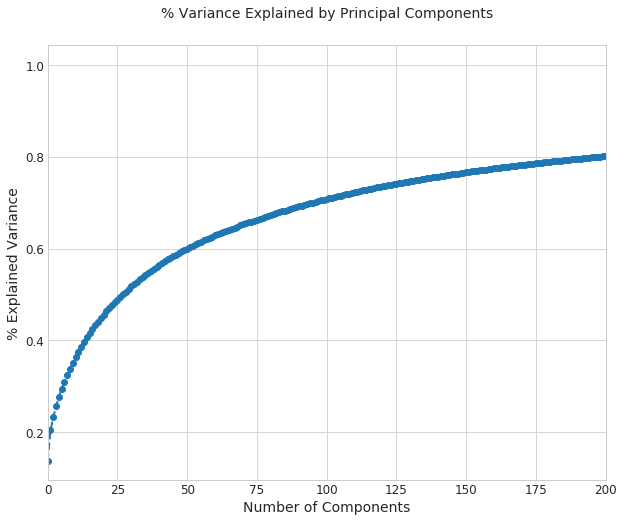

In [57]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [58]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

array([ 197,  198,  199, ..., 6213, 6214, 6215])

In [59]:
pca=PCA(n_components=197,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 167 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 167 components is: 0.79923091576


In [60]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [61]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,197).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.873123100071
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27635   203    27838
True        3929   800     4729
__all__    31564  1003    32567

Accuracy of the model for test data is: 0.861581920904
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6852    88     6940
True        1039   163     1202
__all__     7891   251     8142



Logistic Regression
Accuracy of the model for training data is: 0.882212055148
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24658  3180    27838
True         656  4073     4729
__all__    25314  7253    32567

Accuracy of the model for test data is: 0.882829771555
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6150   790     6940
True         164  1038     1202
__all__     6314  1828     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.90990880339
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25028  2810    27838
True         124  4605     4729
__all__    25152  7415    32567

Accuracy of the model for test data is: 0.897690985016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6218   722     6940
True         111  1091     1202
__all__     6329  1813     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.890963245003
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24915  2923    27838
True         628  4101     4729
__all__    25543  7024    32567

Accuracy of the model for test data is: 0.888970768853
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6208   732     6940
True         172  1030     1202
__all__     6380  1762     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.898793256978
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25036  2802    27838
True         494  4235     4729
__all__    25530  7037    32567

Accuracy of the model for test data is: 0.894374846475
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6217   723     6940
True         137  1065     1202
__all__     6354  1788     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.912488101452
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25035  2803    27838
True          47  4682     4729
__all__    25082  7485    32567

Accuracy of the model for test data is: 0.89756816507
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6217   723     6940
True         111  1091     1202
__all__     6328  1814     8142



Bagging Classifier
Accuracy of the model for training data is: 0.910307980471
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25030  2808    27838
True         113  4616     4729
__all__    25143  7424    32567

Accuracy of the model for test data is: 0.897936624908
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6217   723     6940
True         108  1094     1202
__all__     6325  1817     8142



Neural Network-1
The accuracy of the model on training data is: 0.903429852314


Predicted  False  True  __all__
Actual                         
False      24752  3086    27838
True          59  4670     4729
__all__    24811  7756    32567

The accuracy of the model on test data is: 0.888725128961


Predicted  False  True  __all__
Actual                         
False       6122   818     6940
True          88  1114     1202
__all__     6210  1932     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [62]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [63]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.873123,800.0,27635.0,203.0,3929.0,0.007292,0.830831
LogisticRegression,0.882212,4073.0,24658.0,3180.0,656.0,0.114232,0.138719
RandomForestClassifier,0.909909,4605.0,25028.0,2810.0,124.0,0.100941,0.026221
AdaBoostClassifier,0.890963,4101.0,24915.0,2923.0,628.0,0.105000,0.132798
GradientBoostingClassifier,0.898793,4235.0,25036.0,2802.0,494.0,0.100654,0.104462
ExtraTreeClassifier,0.912488,4682.0,25035.0,2803.0,47.0,0.100690,0.009939
BaggingClassifier,0.910308,4616.0,25030.0,2808.0,113.0,0.100869,0.023895
Neural Network-1,0.903430,4670.0,24752.0,3086.0,59.0,0.110856,0.012476


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.861582,163.0,6852.0,88.0,1039.0,0.012680,0.864393,0.561464,0.252277
LogisticRegression,0.882830,1038.0,6150.0,790.0,164.0,0.113833,0.136439,0.874864,0.637375
RandomForestClassifier,0.897691,1091.0,6218.0,722.0,111.0,0.104035,0.092346,0.901810,0.685198
AdaBoostClassifier,0.888971,1030.0,6208.0,732.0,172.0,0.105476,0.143095,0.875715,0.647302
GradientBoostingClassifier,0.894375,1065.0,6217.0,723.0,137.0,0.104179,0.113977,0.890922,0.669954
ExtraTreeClassifier,0.897568,1091.0,6217.0,723.0,111.0,0.104179,0.092346,0.901738,0.684940
BaggingClassifier,0.897937,1094.0,6217.0,723.0,108.0,0.104179,0.089850,0.902986,0.686663
Neural Network-1,0.888725,1114.0,6122.0,818.0,88.0,0.117867,0.073211,0.902986,0.674511


In [64]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')